In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, classification_report

from skimage.morphology import closing, disk, square
from tools import *
from plot import *
from preprocessing import *

# Loading data

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

# Anomaly Detection

Analysis of images using RX Anomaly Detector

The goal of RX anomaly detector is to highlight pixels of the HSI that are spectraly different from the background. Detecting these outlier pixels is uselfull to know which pixels can contribute to misclassification. 

Paper Link: https://arxiv.org/pdf/2012.05799.pdf

Only the linear version is implemented.

In [4]:
anomaly_indiana = RX_anomaly_detector(indiana_img)
anomaly_salinas = RX_anomaly_detector(salinas_img)

We can directly notice that the Indiana's pixels will be more difficult to classify than Salinas' ones.

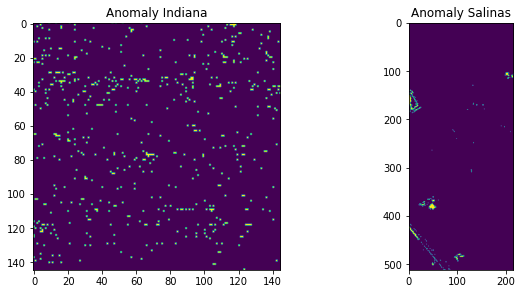

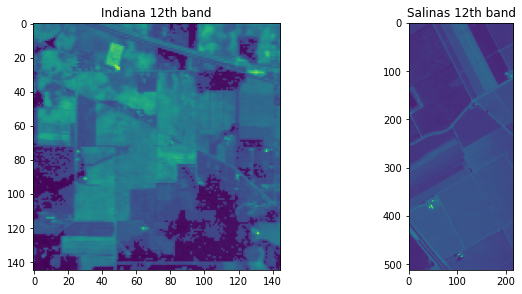

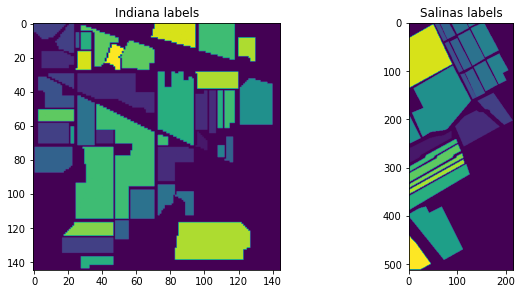

In [5]:
plot_two_figures(anomaly_indiana > 255000, anomaly_salinas >1200, 'Anomaly Indiana', 'Anomaly Salinas')
plot_two_figures(indiana_img[:, :, 12], salinas_img[:, :, 12], 'Indiana 12th band', 'Salinas 12th band')
plot_two_figures(indiana_labels, salinas_labels, 'Indiana labels', 'Salinas labels')

# Classes analysis

Histogram of each classes

In [6]:
indiana_labels_usefull, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels_usefull, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

We have a highly unbalanced dataset (for both images)

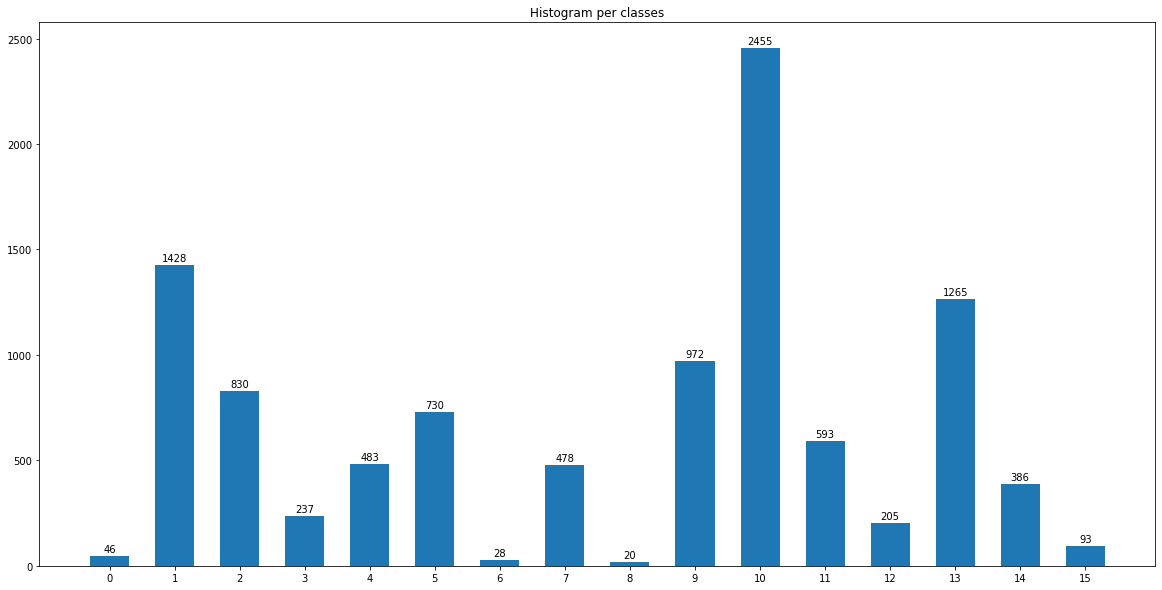

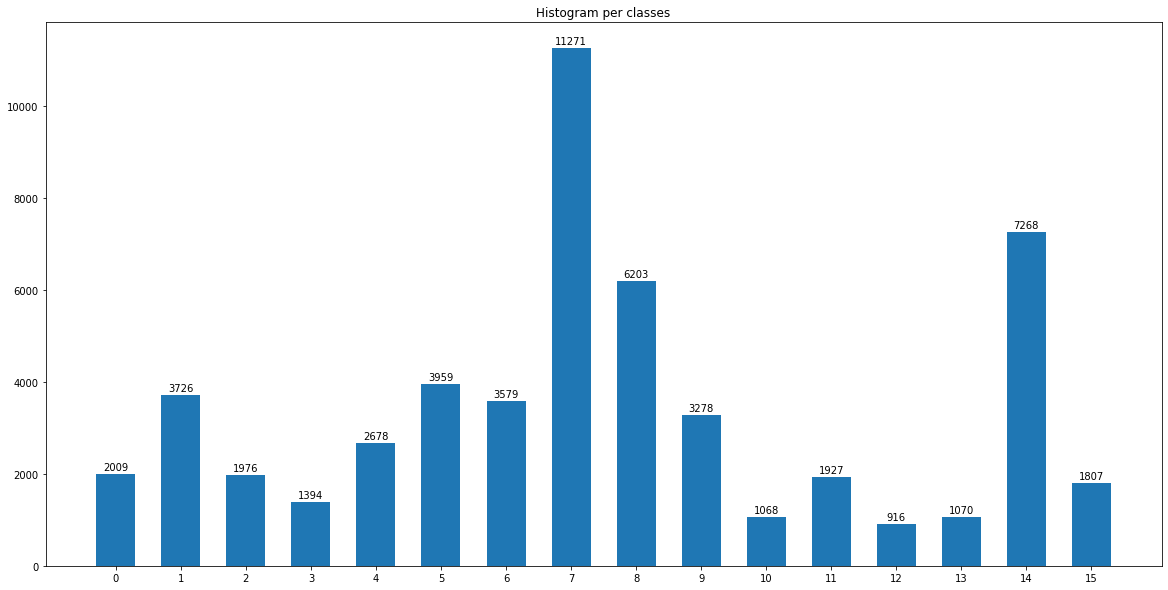

In [7]:
plot_histogram(indiana_labels_usefull-1, figsize=(20,10))
plot_histogram(salinas_labels_usefull-1, figsize=(20,10))

# Bands analysis

Plot different bands

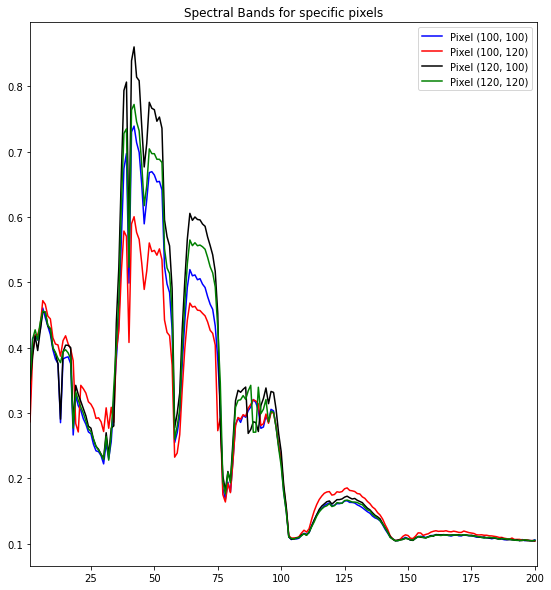

In [8]:
plot_bands(indiana_img)

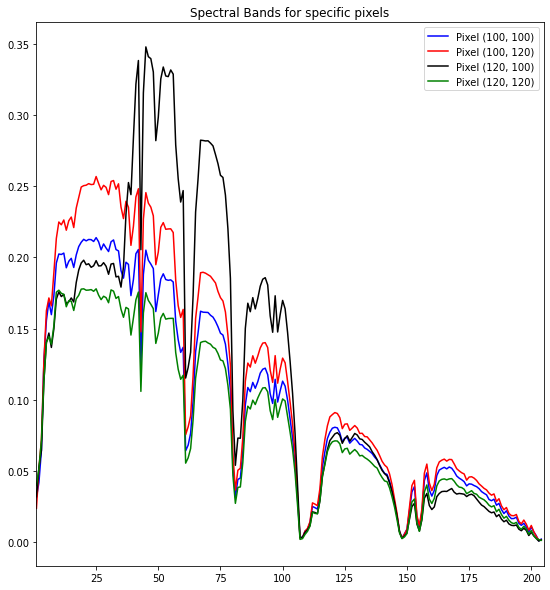

In [9]:
plot_bands(salinas_img)

Compute correlation between two successive bands

In [10]:
band=100

In [11]:
np.corrcoef(salinas_img[:,:,band].ravel(),salinas_img[:,:,band+1].ravel())

array([[1.        , 0.99601356],
       [0.99601356, 1.        ]])

In [12]:
np.corrcoef(indiana_img[:,:,band].ravel(),indiana_img[:,:,band+1].ravel())

array([[1.        , 0.98390018],
       [0.98390018, 1.        ]])

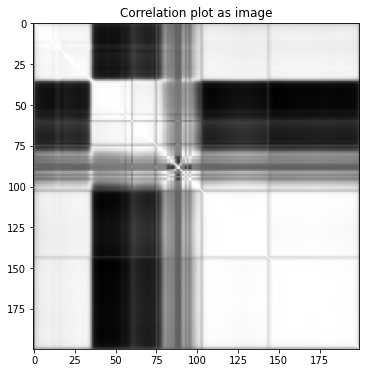

In [13]:
plot_correlation(indiana_img.reshape((-1, indiana_img.shape[-1])))

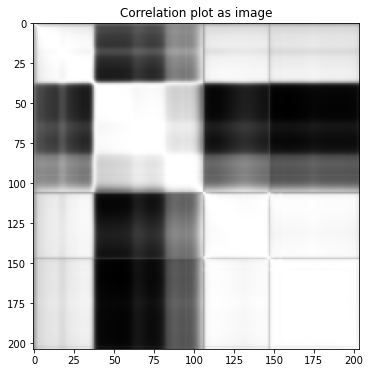

In [14]:
plot_correlation(salinas_img.reshape((-1, salinas_img.shape[-1])))

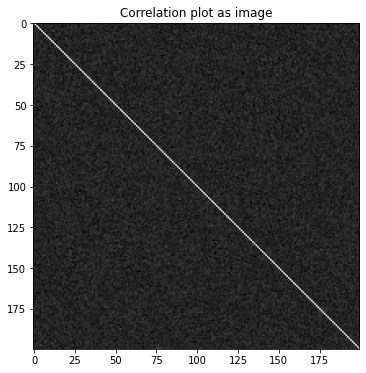

In [15]:
random_data = np.random.random_sample((500,200))
plot_correlation(random_data)

# PCA analysis

Use PCA (principal component analysis) to extract features.
Check how many features can be extracted without loosing too much information

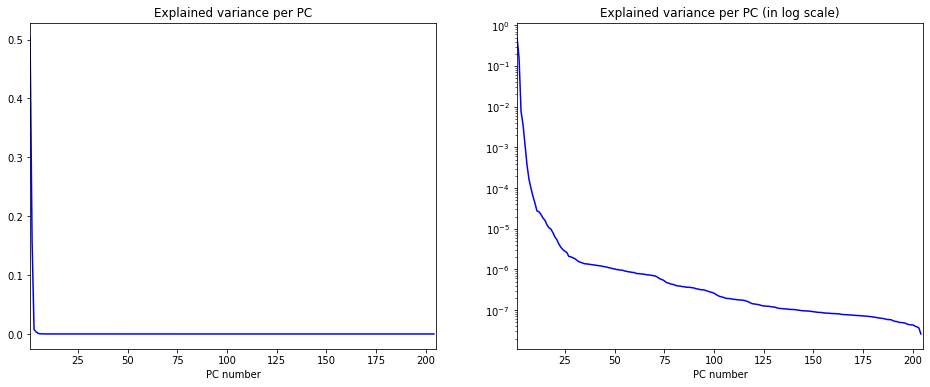

In [16]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
pca_model_salinas = plot_pca_components(X_salinas)

Here the first component gives 74.4% of the variance information (linear information) of the dataset.
The second one gives 23.5% of the variance information in the dataset.

In [17]:
pca_model_salinas.explained_variance_ratio_[:10]

array([7.44737128e-01, 2.35313246e-01, 1.13412373e-02, 5.40387401e-03,
       1.73644644e-03, 5.49967557e-04, 2.41974056e-04, 1.46639093e-04,
       9.24879478e-05, 6.31532120e-05])

By using cumsum numpy function we can bring out the number of components we need to have to keep 99.9% of the variance in the dataset.

In [18]:
pca_model_salinas.explained_variance_ratio_.cumsum()[:10]

array([0.74473713, 0.98005037, 0.99139161, 0.99679549, 0.99853193,
       0.9990819 , 0.99932387, 0.99947051, 0.999563  , 0.99962615])

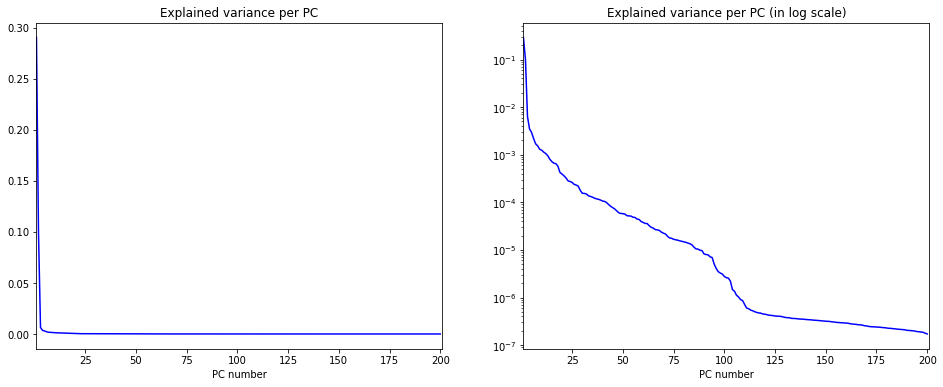

In [19]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
pca_model_indiana = plot_pca_components(X_indiana)

Here the first component gives 68.4% of the variance information (linear information) of the dataset.
The second one gives 23.5% of the variance information in the dataset.

In [20]:
pca_model_indiana.explained_variance_ratio_[:10]

array([0.68493799, 0.23531371, 0.01496355, 0.00821542, 0.00695011,
       0.00517011, 0.00399681, 0.0036236 , 0.00307127, 0.00293212])

In [21]:
pca_model_indiana.explained_variance_ratio_.cumsum()[:70]

array([0.68493799, 0.9202517 , 0.93521525, 0.94343066, 0.95038078,
       0.95555088, 0.9595477 , 0.96317129, 0.96624257, 0.96917469,
       0.97184822, 0.97434052, 0.9765874 , 0.97848129, 0.98017563,
       0.98173606, 0.98326769, 0.98461782, 0.98561921, 0.98654408,
       0.98739196, 0.98815635, 0.98882094, 0.98946662, 0.99008298,
       0.99064439, 0.99118755, 0.99170313, 0.99212421, 0.99248924,
       0.99285195, 0.99320518, 0.99352922, 0.99384291, 0.9941463 ,
       0.99443403, 0.9947132 , 0.99498593, 0.99524891, 0.99549922,
       0.99574534, 0.99597757, 0.99618893, 0.99638301, 0.99656499,
       0.99673583, 0.99689158, 0.99703347, 0.99717081, 0.99730724,
       0.99744073, 0.9975641 , 0.99768598, 0.99780697, 0.99792172,
       0.99803484, 0.9981398 , 0.99824276, 0.99833589, 0.99842502,
       0.99850998, 0.99859416, 0.99867021, 0.99874048, 0.99880823,
       0.99887108, 0.99893342, 0.99899374, 0.9990494 , 0.99910236])